### **Proyecto #1 Inteligencia de Negocios: Analítica de Textos**

Autores:
*   Martin Santiago Galvan Castro
*   Ernesto Carlos Perez Covo
*   Juan Sebastian Nuñez Cortes


### **0. Instalacion e imports de librerias**

In [1]:
import sys
# Version 3.8 de Python requerida. De lo contrario, NO se ejecutará el programa.

#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install contexto
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install openpyxl
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install langdetect

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from contexto.limpieza import limpieza_texto, lista_stopwords, remover_stopwords
from contexto.stemming import Stemmer, stem_texto
from contexto.vectorizacion import VectorizadorFrecuencias

from joblib import dump

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from pipelineClasses import TextTransformer
from pipelineClasses import NormalizeTokens
from pipelineClasses import VectorizeTokens

from langdetect import detect

### **1. Exploracion de datos**

In [3]:
df = pd.read_excel('cat_6716.xlsx')

In [4]:
# Contar valores nulos
df.isnull().sum()

Textos_espanol    0
sdg               0
dtype: int64

In [5]:
# Contar duplicados
df.duplicated().sum()

0

In [6]:
# Detectar si hay otros idiomas ademas de español.
df['lang'] = df['Textos_espanol'].apply(lambda x: detect(x))
df['lang'].value_counts()

lang
es    2997
en       3
Name: count, dtype: int64

In [7]:
# Imprimir los textos que no son español
for i in range(len(df)):
    if df['lang'][i] != 'es':
       print(i, df['Textos_espanol'][i])

1317 Project Finance NewsWire, Discussion with four project finance bankers, moderated by Rohit Chadhry, Chadboume & Parke, pp. Investment Monitor 2Q 2010, vol. Policy instrument design to reduce financing costs in renewable energy technology projects, ECOFYS, Utrecht. Reestructuración de una red verde: Legal challenges to accommodate new renewable energy infrastructure. Environmental Law, 39, 977-1014. 
1553 Innovación en tecnología energética: Aprender de los éxitos y fracasos históricos. New York: Cambridge University Press. Transformation Patterns of the Worldwide Energy Systemâ€"Scenarios for the Century with the POLES Model.â€ The Energy Journal 31 (Special Issue: The Economics of Low Stabilization): 49-82.
1950 Empleos verdes y energías renovables: Low carbon, high employment, www.ilo.org/ green-jobs-programme. Contabilizando el coste de las subvenciones energéticas. Poor Numbers: How we are Misled by African Development Statistics and What to Do About It, Ithaca: Cornell Univer

In [8]:
# Hay unicamente una frase en ingles, las otras tienen porciones tanto en español como en ingles. No se elimina ninguna debio a que, al probarlo, se redujo la precision del modelo.
# df = df[df['lang'] == 'es']
# df['lang'].value_counts()

In [9]:
df['Conteo'] = [len(x) for x in df['Textos_espanol']]
df['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in df['Textos_espanol']]
df['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in df['Textos_espanol']]
df['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in df['Textos_espanol']]

In [10]:
# Se genero un reporte con ydata_profiling. Se guardo este reporte bajo el nombre report.html
# profile = ProfileReport(df)
# profile.to_file("report.html")

<Axes: xlabel='Conteo', ylabel='Count'>

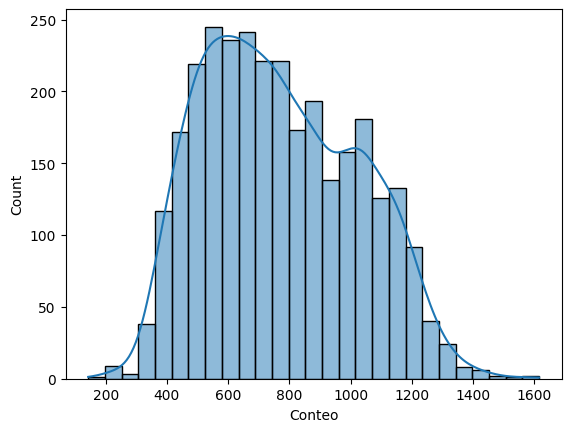

In [11]:
sns.histplot(data=df, x='Conteo', kde=True)

<Axes: xlabel='Min', ylabel='Count'>

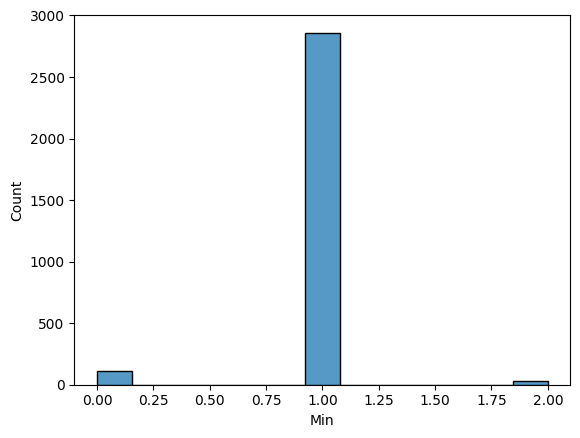

In [12]:
sns.histplot(data=df, x='Min')

<Axes: xlabel='Max'>

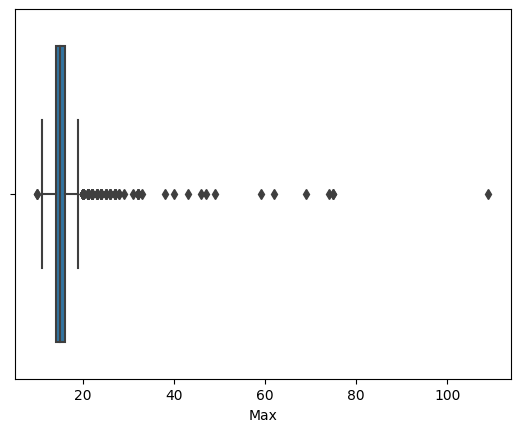

In [13]:
sns.boxplot(x=df['Max'])

In [14]:
df['Moda'].value_counts()

Moda
de            2366
la             353
y               80
en              57
los             34
el              32
las             16
para            10
a                8
del              7
que              6
agua             3
derecho          3
un               3
the              2
se               2
por              2
La               2
and              1
to               1
historia         1
Capítulo         1
ha               1
beneficios       1
impuestos        1
sobre            1
lago             1
Clase            1
costo            1
datos            1
río              1
opiniones        1
Name: count, dtype: int64

In [15]:
df.head()

,Textos_espanol,sdg,lang,Conteo,Moda,Max,Min
0,"Es importante destacar que, en un año de sequí...",6,es,621,de,16,1
1,Hay una gran cantidad de literatura sobre Aust...,6,es,881,de,15,1
2,"Los procesos de descentralización, emprendidos...",6,es,579,la,18,1
3,Esto puede tener consecuencias sustanciales pa...,6,es,706,de,14,1
4,La función de beneficio también incorpora pará...,6,es,673,de,12,1


### **2. Separacion de datos**

In [16]:
X, Y = df['Textos_espanol'], df['sdg']
Y = Y.astype(int)
Y.head()

0    6
1    6
2    6
3    6
4    6
Name: sdg, dtype: int32

In [17]:
X.head()

0    Es importante destacar que, en un año de sequí...
1    Hay una gran cantidad de literatura sobre Aust...
2    Los procesos de descentralización, emprendidos...
3    Esto puede tener consecuencias sustanciales pa...
4    La función de beneficio también incorpora pará...
Name: Textos_espanol, dtype: object

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [19]:
X_train.head()

2370    Lograr el respeto de los derechos humanos por ...
1774    Diseño de proyectos sostenibles de electrifica...
731     En las partes españolas de las cuencas del Due...
271     Garantizar que los arreglos de gobernanza ayud...
1077    Además, a nivel de plantas y unidades, no hay ...
Name: Textos_espanol, dtype: object

### **3. Modelo #1: Naive Bayes**

Para el pipeline, se realiza la limpieza, normalización (stemmming), vectorización y clasificación de los datos. Las clases que realizan los pasos del pipeline se importaron desde un archivo .py (pipelineClasses.py) para garantizar la persistencia del modelo (etapa 2 del proyecto).

Sin las clases no se importan desde un archivo externo, el modelo no almacena correctamente en el archivo joblib. Por lo tanto, se creó un archivo .py con las clases necesarias para el pipeline. Estas son las mismas clases que se construyeron en el notebook de la etapa 1. Simplemente se copiaron y pegaron en el archivo .py.

In [20]:
# Entrenamiento y construcción del modelo. Se utiliza como clasificador un Complement Naive Bayes.
pipelineCNB = Pipeline(
    [
        ("text_transformer", TextTransformer()),
        ("normalize_tokens", NormalizeTokens()),
        ("vectorize_tokens", VectorizeTokens()),
        ("classifier", ComplementNB())
    ]
)   
pipelineCNB.fit(X_train, Y_train)

Pipeline(steps=[('text_transformer', TextTransformer()),
                ('normalize_tokens', NormalizeTokens()),
                ('vectorize_tokens', VectorizeTokens()),
                ('classifier', ComplementNB())])

In [21]:
# Evaluación del modelo con los datos de prueba.
y_pred = pipelineCNB.predict(X_test)

In [22]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (X_test.shape[0], (Y_test != y_pred).sum()))
print("Porcentaje de acierto: ", (Y_test == y_pred).sum() / Y_test.shape[0] * 100)

Number of mislabeled points out of a total 600 points : 10
Porcentaje de acierto:  98.33333333333333


In [23]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           6       1.00      0.97      0.98       237
           7       0.98      0.99      0.99       187
          16       0.97      0.99      0.98       176

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



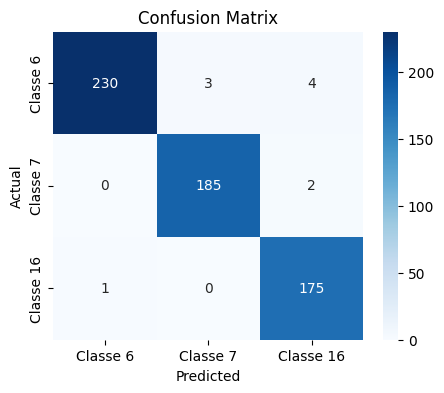

In [24]:
# Matriz de confusión
conf_matrix = confusion_matrix(Y_test, y_pred)

# Etiquetas de las clases
class_labels = ['Classe 6', 'Classe 7', 'Classe 16']

# Heatmap de la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **4. Modelo #2: SVM**

In [25]:
"""
Entrenamiento y construcción del modelo. 
SGDC Classifier, cuando tiene el parametro de hinge, implementa SVM lineal. Se implementa de esta manera para no tener que lidear con 
el kernel, y los resultados que da son suficientemenet satisfactorios.
"""

pipelineSDG = Pipeline(
    [
        ("text_transformer", TextTransformer()),
        ("normalize_tokens", NormalizeTokens()),
        ("vectorize_tokens", VectorizeTokens()),
        ("classifier", SGDClassifier(loss='hinge', penalty='l2',
                    alpha=1e-3, max_iter=5, tol=None)) 
    ]
) 

In [26]:
parameters = {
    'vectorize_tokens__tipo_vec': ('bow', 'tfidf'),
    'classifier__alpha': (1e-2,1e-3),
    'classifier__penalty': ('l2','l1')
}

In [27]:
gs_pipelineSDG = GridSearchCV(pipelineSDG, parameters, cv=5, n_jobs=-1)

In [28]:
gs_pipelineSDG.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('text_transformer', TextTransformer()),
                                       ('normalize_tokens', NormalizeTokens()),
                                       ('vectorize_tokens', VectorizeTokens()),
                                       ('classifier',
                                        SGDClassifier(alpha=0.001, max_iter=5,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': (0.01, 0.001),
                         'classifier__penalty': ('l2', 'l1'),
                         'vectorize_tokens__tipo_vec': ('bow', 'tfidf')})

In [29]:
gs_pipelineSDG.best_params_

{'classifier__alpha': 0.001,
 'classifier__penalty': 'l2',
 'vectorize_tokens__tipo_vec': 'tfidf'}

In [30]:
best_pipelineSDG = gs_pipelineSDG.best_estimator_

In [31]:
# Evaluación del modelo con los datos de prueba.
y_pred = best_pipelineSDG.predict(X_test)

In [32]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (X_test.shape[0], (Y_test != y_pred).sum()))
print("Porcentaje de acierto: ", (Y_test == y_pred).sum() / Y_test.shape[0] * 100)

Number of mislabeled points out of a total 600 points : 10
Porcentaje de acierto:  98.33333333333333


In [33]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           6       0.98      0.98      0.98       237
           7       0.98      0.98      0.98       187
          16       0.98      0.99      0.99       176

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



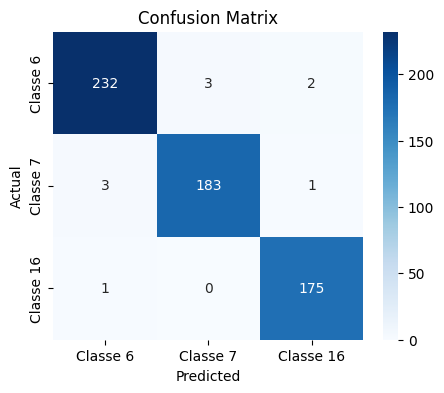

In [34]:
# Matriz de confusión
conf_matrix = confusion_matrix(Y_test, y_pred)

# Etiquetas de las clases
class_labels = ['Classe 6', 'Classe 7', 'Classe 16']

# Heatmap de la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **5. Modelo #3: Random Forest**

In [35]:
rfc = RandomForestClassifier(random_state=0, bootstrap=False, max_depth=100, n_estimators=184, min_samples_leaf=1, min_samples_split=5, criterion='gini')

pipelineRFC = Pipeline(
    [
        ("text_transformer", TextTransformer()),
        ("normalize_tokens", NormalizeTokens()),
        ("vectorize_tokens", VectorizeTokens()),
        ("classifier", rfc) 
    ]
)

In [36]:
pipelineRFC.fit(X_train, Y_train)

Pipeline(steps=[('text_transformer', TextTransformer()),
                ('normalize_tokens', NormalizeTokens()),
                ('vectorize_tokens', VectorizeTokens()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=100,
                                        min_samples_split=5, n_estimators=184,
                                        random_state=0))])

In [37]:
# Evaluación del modelo con los datos de prueba.
y_pred = pipelineRFC.predict(X_test)

In [38]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (X_test.shape[0], (Y_test != y_pred).sum()))
print("Porcentaje de acierto: ", (Y_test == y_pred).sum() / Y_test.shape[0] * 100)

Number of mislabeled points out of a total 600 points : 11
Porcentaje de acierto:  98.16666666666667


In [39]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           6       0.99      0.96      0.98       237
           7       0.97      0.99      0.98       187
          16       0.98      0.99      0.99       176

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



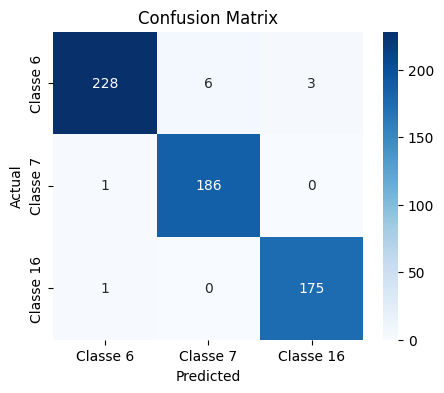

In [40]:
# Matriz de confusión
conf_matrix = confusion_matrix(Y_test, y_pred)

# Etiquetas de las clases
class_labels = ['Classe 6', 'Classe 7', 'Classe 16']

# Heatmap de la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **6. Etiquetado de datos con el mejor modelo**

Para etiquetar los datos, se utiliza el mejor modelo, que en este caso es el de Naive Bayes. A pesar de que en algunos casos el modelo de SGD tiene un mejor accuracy, este no es consistente, ya que de vez en cuando se obtienen 9,11,12 o 14 de 600 resultados incorrectos. Por lo tanto, se decide utilizar el modelo de Naive Bayes, el cual tiene un porcentaje de acierto de 98.33% en la clasificación de los datos.

In [41]:
df_sin_etiquetas = pd.read_excel('SinEtiquetatest_cat_6716.xlsx')

In [42]:
# Se cuenta con 980 registros y 2 columnas
df_sin_etiquetas.shape

(980, 2)

In [43]:
df_sin_etiquetas.head()

,Textos_espanol,sdg
0,1. 1. Introducción: Las Estructuras del Derech...,NaN
1,Las aguas subterráneas se han debatido en el c...,NaN
2,La presente contribución evalúa la jurispruden...,NaN
3,"Sin embargo, este crédito fiscal expira en 201...",NaN
4,"Este estudio explora las actitudes, comportami...",NaN


In [44]:
datos_etiquetados = pipelineCNB.predict(df_sin_etiquetas['Textos_espanol'])

In [45]:
datos_etiquetados.shape

(980,)

In [46]:
datos_etiquetados[:5]

array([16,  6, 16,  7, 16])

In [47]:
# Agregar las etiquetas al dataframe
df_sin_etiquetas['sdg'] = datos_etiquetados

In [48]:
df_sin_etiquetas.head()

,Textos_espanol,sdg
0,1. 1. Introducción: Las Estructuras del Derech...,16
1,Las aguas subterráneas se han debatido en el c...,6
2,La presente contribución evalúa la jurispruden...,16
3,"Sin embargo, este crédito fiscal expira en 201...",7
4,"Este estudio explora las actitudes, comportami...",16


In [49]:
df_sin_etiquetas.to_csv('EtiquetadosTest_cat_6716.csv', index=False)

### **7. Exportar el modelo en archivo .joblib**

In [50]:
filename = 'modeloCNB.joblib'

In [51]:
dump(pipelineCNB, filename)

['modeloCNB.joblib']